#1 高斯混合模型调参

[[1 0]
 [0 2]]
错误率： [ 0.385    0.315    0.3      0.00125]
BIC： [ 7990.71460065  7855.56050855  8006.49834359  6845.79374805]


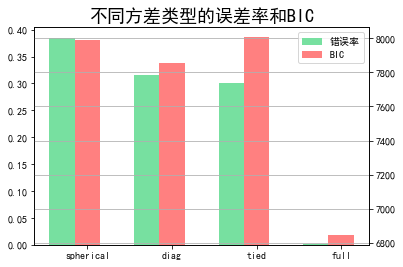

均值 = 
 [[ -0.97642254  10.06927801]
 [  2.88444448   6.69484552]]
方差 = 
 [[[  0.91302546  -0.04298504]
  [ -0.04298504   1.9603531 ]]

 [[  2.87015473   6.64421303]
  [  6.64421303  18.00318872]]]


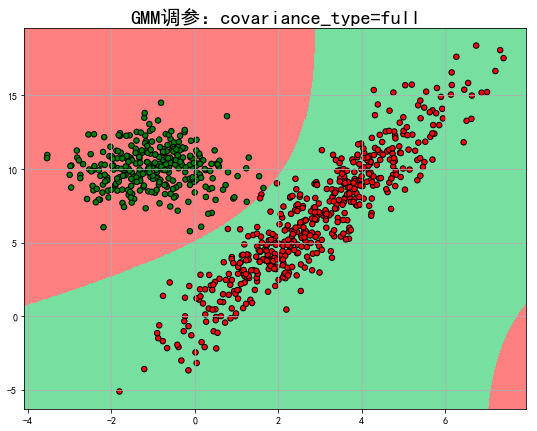

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d


def accuracy_rate(y1, y2):
    acc = np.mean(y1 == y2)
    return acc if acc > 0.5 else 1-acc

np.random.seed(0)
cov1 = np.diag((1, 2))
print(cov1)
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(1, 2), cov=cov1, size=N1)
m = np.array(((1, 1), (1, 3)))
x1 = x1.dot(m)
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)

types = ('spherical', 'diag', 'tied', 'full')
err = np.empty(len(types))
bic = np.empty(len(types))
for i, type in enumerate(types):
    gmm = GaussianMixture(n_components=2, covariance_type=type, random_state=0)
    gmm.fit(x)
    err[i] = 1 - accuracy_rate(gmm.predict(x), y)
    bic[i] = gmm.bic(x)
print('错误率：', err.ravel())
print('BIC：', bic.ravel())
xpos = np.arange(4)
plt.figure(facecolor='w')
ax = plt.axes()
b1 = ax.bar(xpos-0.3, err, width=0.3, color='#77E0A0')
b2 = ax.twinx().bar(xpos, bic, width=0.3, color='#FF8080')
plt.grid(True)
bic_min, bic_max = expand(bic.min(), bic.max())
plt.ylim((bic_min, bic_max))
plt.xticks(xpos, types)
plt.legend([b1[0], b2[0]], (u'错误率', u'BIC'))
plt.title(u'不同方差类型的误差率和BIC', fontsize=18)
plt.show()

optimal = bic.argmin()
gmm = GaussianMixture(n_components=2, covariance_type=types[optimal], random_state=0)
gmm.fit(x)
print('均值 = \n', gmm.means_)
print('方差 = \n', gmm.covariances_)
y_hat = gmm.predict(x)

cm_light = mpl.colors.ListedColormap(['#FF8080', '#77E0A0'])
cm_dark = mpl.colors.ListedColormap(['r', 'g'])
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
if gmm.means_[0][0] > gmm.means_[1][0]:
    z = grid_hat == 0
    grid_hat[z] = 1
    grid_hat[~z] = 0
plt.figure(figsize=(9, 7), facecolor='w')
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, marker='o', cmap=cm_dark, edgecolors='k')

ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title(u'GMM调参：covariance_type=%s' % types[optimal], fontsize=20)
plt.grid()
plt.show()

#2 GMM似然函数值

GMM均值 = 
 [[ -0.9854541   10.07568927]
 [  4.88245286   8.69755   ]]
GMM方差 = 
 [[[  0.89072605  -0.02570275]
  [ -0.02570275   1.95107155]]

 [[  2.86653758   6.62893122]
  [  6.62893122  17.97377445]]]
[-29.75101362 -29.9079518  -30.06590288 ...,  -8.08772322  -8.10398308
  -8.12125586]


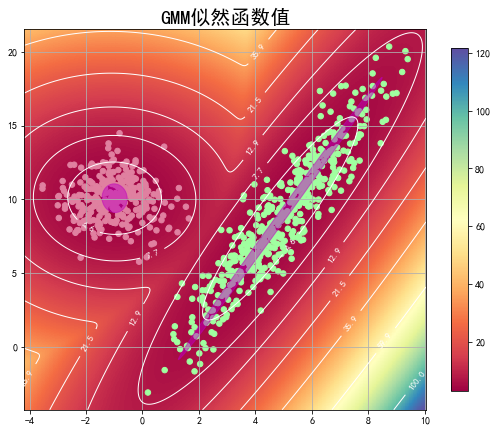

In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy as sp
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings


def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d

warnings.filterwarnings(action='ignore', category=RuntimeWarning)
np.random.seed(0)
cov1 = np.diag((1, 2))
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(3, 2), cov=cov1, size=N1)
m = np.array(((1, 1), (1, 3)))
x1 = x1.dot(m)
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(x)
centers = gmm.means_
covs = gmm.covariances_
print('GMM均值 = \n', centers)
print('GMM方差 = \n', covs)
y_hat = gmm.predict(x)

colors = '#A0FFA0', '#E080A0',
levels = 10
cm = mpl.colors.ListedColormap(colors)
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
print(gmm.score_samples(grid_test))
grid_hat = -gmm.score_samples(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
plt.figure(figsize=(9, 7), facecolor='w')
ax = plt.subplot(111)
cmesh = plt.pcolormesh(x1, x2, grid_hat, cmap=plt.cm.Spectral)
plt.colorbar(cmesh, shrink=0.9)
CS = plt.contour(x1, x2, grid_hat, levels=np.logspace(0, 2, num=levels, base=10), colors='w', linewidths=1)
plt.clabel(CS, fontsize=9, inline=True, fmt='%.1f')
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

for i, cc in enumerate(zip(centers, covs)):
    center, cov = cc
    value, vector = sp.linalg.eigh(cov)
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color='m', alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.title(u'GMM似然函数值', fontsize=20)
plt.grid(True)
plt.show()

#3 GMM与DPGMM的比较

GMM均值 = 
 [[ -0.98543679  10.0756839 ]
 [  6.0239399   11.61448122]
 [  3.77430768   5.86579463]]
GMM方差 = 
 [[[  0.89079177  -0.02572518]
  [ -0.02572518   1.95106592]]

 [[  1.6667472    3.58655076]
  [  3.58655076  10.40673433]]

 [[  1.5383593    3.21210121]
  [  3.21210121   9.04107582]]]


DPGMM均值 = 
 [[  4.87807808   8.69858646]
 [ -0.97320511  10.07279749]
 [  2.68191465   9.21436833]]
DPGMM方差 = 
 [[[  2.88507577   6.60477348]
  [  6.60477348  17.92760296]]

 [[  0.96326411  -0.02865043]
  [ -0.02865043   1.98179578]]

 [[  5.104264     1.12039777]
  [  1.12039777   6.21286898]]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 

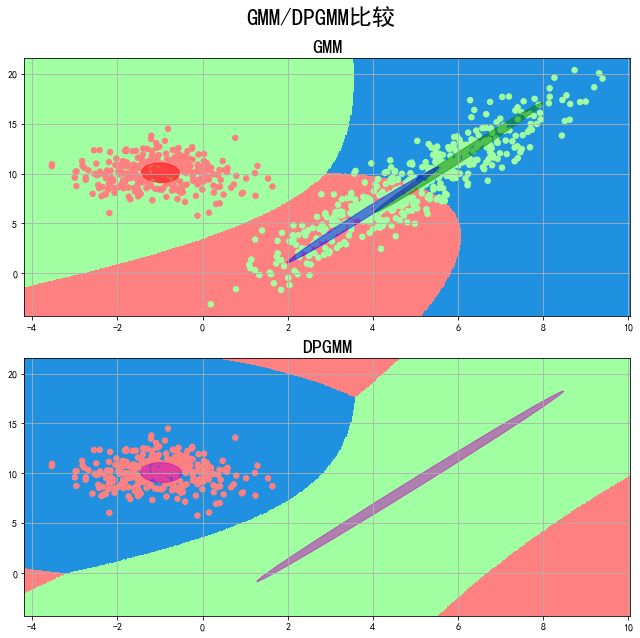

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import scipy as sp
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d

matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

np.random.seed(0)
cov1 = np.diag((1, 2))
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(3, 2), cov=cov1, size=N1)
m = np.array(((1, 1), (1, 3)))
x1 = x1.dot(m)
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)
n_components = 3

# 绘图使用
colors = '#A0FFA0', '#2090E0', '#FF8080'
cm = mpl.colors.ListedColormap(colors)
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)

plt.figure(figsize=(9, 9), facecolor='w')
plt.suptitle(u'GMM/DPGMM比较', fontsize=23)

ax = plt.subplot(211)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(x)
centers = gmm.means_
covs = gmm.covariances_
print('GMM均值 = \n', centers)
print('GMM方差 = \n', covs)
y_hat = gmm.predict(x)

grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
plt.pcolormesh(x1, x2, grid_hat, cmap=cm)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

clrs = list('rgbmy')
for i, (center, cov) in enumerate(zip(centers, covs)):
    value, vector = sp.linalg.eigh(cov)
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color=clrs[i], alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title(u'GMM', fontsize=20)
plt.grid(True)

# DPGMM
dpgmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000, n_init=5,
                                weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=0.1)
dpgmm.fit(x)
centers = dpgmm.means_
covs = dpgmm.covariances_
print('DPGMM均值 = \n', centers)
print('DPGMM方差 = \n', covs)
y_hat = dpgmm.predict(x)
print(y_hat)

ax = plt.subplot(212)
grid_hat = dpgmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
plt.pcolormesh(x1, x2, grid_hat, cmap=cm)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

for i, cc in enumerate(zip(centers, covs)):
    if i not in y_hat:
        continue
    center, cov = cc
    value, vector = sp.linalg.eigh(cov)
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color='m', alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title('DPGMM', fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()